In [1]:
import numpy as np
from implementations import *
from helpers import *
import matplotlib.pyplot as plt
from functions import *

np.random.seed(123)

In [2]:
_, _, y_train, train_ids, test_ids = load_csv_data(data_path='data/dataset')
y_train = np.where(y_train == -1, 0, 1)
x_train = np.load('new_data/cleaned_data.npy')
x_train_norm = standardize(x_train)
x_train_norm = np.hstack((np.reshape(np.ones(x_train_norm.shape[0]), (x_train_norm.shape[0],1)), x_train_norm))

N, D = x_train_norm.shape

In [3]:
y_train_final, x_train_final, y_val_final, x_val_final, indices_train = split_balanced(y_train, x_train_norm, 0.95)

#### Check loss trend on different regression methods

In [4]:
# parameters
max_iters = 1000
learning_rate = 0.05

# Initialize the weight vector
initial_w = np.ones(x_train_final.shape[1])

LINEAR REGRESSION GD

In [5]:
_, loss_mse = mean_squared_error_gd_loss_tracking(y_train_final, x_train_final, initial_w, max_iters, learning_rate)

LINEAR REGRESSION BATCH SGD

In [6]:
_, loss_batch_mse = mean_squared_error_sgd_loss_tracking_batch(y_train_final, x_train_final, initial_w, max_iters, learning_rate)

LOGISTIC REGRESSION

In [7]:
_, loss_logistic = logistic_regression_gd_loss_tracking(y_train_final, x_train_final, initial_w, max_iters, learning_rate)

Plot the losses

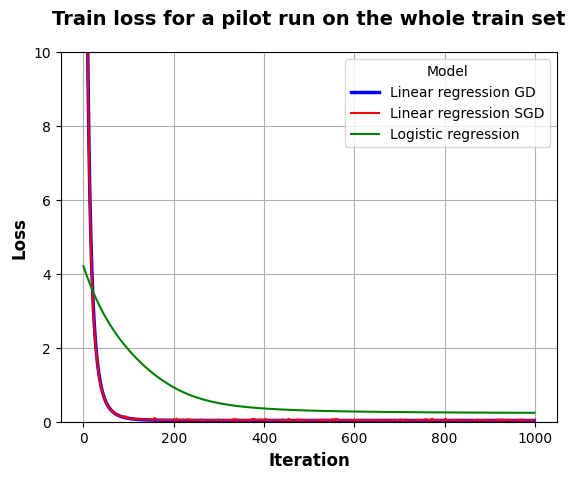

In [ ]:
# plot the loss
plt.figure(figsize=(8,5))
plt.plot(loss_mse, 'b-', label='Linear regression GD', lw=2.5)
plt.plot(loss_batch_mse, 'r-', label='Linear regression SGD')
plt.plot(loss_logistic, 'g-', label='Logistic regression')

plt.ylim((0,10))
plt.xlabel('Iteration', fontsize=12, weight='bold')
plt.ylabel('Loss',  fontsize=12, weight='bold')
plt.title(f'Train loss for a pilot run on the whole train set', fontsize=14, weight='bold', pad=20)
plt.legend(title="Model")
plt.grid(True)

plt.savefig('img/losses.pdf')

plt.show()

#### Tuning the hyperparameter keep_percentage for the different regression methods using k-fold

In [9]:
# setting parameters for the following models

PERCENTAGES = [0.1, 0.3,  0.5, 0.7, 0.9]
N_FOLDS = 4
THRESHOLD = 0.5
MAX_ITERS = 1000
LEARNING_RATE = 0.05
INITIAL_W = np.ones(D)
N = y_train_final.shape[0]

Linear regression full gradient

In [10]:
lin_gd_f1s = np.zeros(len(PERCENTAGES))
lin_gd_accuracies = np.zeros(len(PERCENTAGES))

folds = balanced_k_folds(y_train_final, N_FOLDS)

for j, p in enumerate(PERCENTAGES):
    p_f1s = np.zeros(N_FOLDS)
    p_accuracies = np.zeros(N_FOLDS)
    
    for i in range(N_FOLDS):
        fold = folds[i]
        rest = np.setdiff1d(np.arange(N), fold)
            
        loc_y_val = y_train_final[fold]
        loc_x_val = x_train_final[fold, :]
        loc_y_train = y_train_final[rest]
        loc_x_train = x_train_final[rest, :]
        loc_x_train, loc_y_train = remove_percentage(loc_x_train, loc_y_train, p)

        w, _ =  mean_squared_error_gd_loss_tracking(loc_y_train, loc_x_train, INITIAL_W, MAX_ITERS, LEARNING_RATE)
        
        p_accuracies[i], p_f1s[i] = accuracy_f1(loc_y_val, loc_x_val, w, THRESHOLD)

    lin_gd_f1s[j] = np.mean(p_f1s)
    lin_gd_accuracies[j] = np.mean(p_accuracies)

Linear regression stochastic gradient descent batch

In [11]:
lin_sgd_f1s = np.zeros(len(PERCENTAGES))
lin_sgd_accuracies = np.zeros(len(PERCENTAGES))

# folds = balanced_k_folds(y_train, N_FOLDS)

for j, p in enumerate(PERCENTAGES):
    p_f1s = np.zeros(N_FOLDS)
    p_accuracies = np.zeros(N_FOLDS)
    
    for i in range(N_FOLDS):
        fold = folds[i]
        rest = np.setdiff1d(np.arange(N), fold)
            
        loc_y_val = y_train_final[fold]
        loc_x_val = x_train_final[fold, :]
        loc_y_train = y_train_final[rest]
        loc_x_train = x_train_final[rest, :]
        loc_x_train, loc_y_train = remove_percentage(loc_x_train, loc_y_train, p)

        w, _ =  mean_squared_error_sgd_loss_tracking_batch(loc_y_train, loc_x_train, INITIAL_W, MAX_ITERS, LEARNING_RATE)
        
        p_accuracies[i], p_f1s[i] = accuracy_f1(loc_y_val, loc_x_val, w, THRESHOLD)
        
    lin_sgd_f1s[j] = np.mean(p_f1s)
    lin_sgd_accuracies[j] = np.mean(p_accuracies)

Linear regression normal equations

In [12]:
lin_ne_f1s = np.zeros(len(PERCENTAGES))
lin_ne_accuracies = np.zeros(len(PERCENTAGES))

# folds = balanced_k_folds(y_train, N_FOLDS)

for j, p in enumerate(PERCENTAGES):
    p_f1s = np.zeros(N_FOLDS)
    p_accuracies = np.zeros(N_FOLDS)
    
    for i in range(N_FOLDS):
        fold = folds[i]
        rest = np.setdiff1d(np.arange(N), fold)
            
        loc_y_val = y_train_final[fold]
        loc_x_val = x_train_final[fold, :]
        loc_y_train = y_train_final[rest]
        loc_x_train = x_train_final[rest, :]
        loc_x_train, loc_y_train = remove_percentage(loc_x_train, loc_y_train, p)

        w, _ =  least_squares(loc_y_train, loc_x_train)
        
        p_accuracies[i], p_f1s[i] = accuracy_f1(loc_y_val, loc_x_val, w, THRESHOLD)

    lin_ne_f1s[j] = np.mean(p_f1s)
    lin_ne_accuracies[j] = np.mean(p_accuracies)

Logistic regression

In [13]:
log_f1s = np.zeros(len(PERCENTAGES))
log_accuracies = np.zeros(len(PERCENTAGES))

# folds = balanced_k_folds(y_train, N_FOLDS)

for j, p in enumerate(PERCENTAGES):
    p_f1s = np.zeros(N_FOLDS)
    p_accuracies = np.zeros(N_FOLDS)
    
    for i in range(N_FOLDS):
        fold = folds[i]
        rest = np.setdiff1d(np.arange(N), fold)
            
        loc_y_val = y_train_final[fold]
        loc_x_val = x_train_final[fold, :]
        loc_y_train = y_train_final[rest]
        loc_x_train = x_train_final[rest, :]
        loc_x_train, loc_y_train = remove_percentage(loc_x_train, loc_y_train, p)

        w, _ = logistic_regression(loc_y_train, loc_x_train, INITIAL_W, MAX_ITERS, LEARNING_RATE)
        
        p_accuracies[i], p_f1s[i] = accuracy_f1(loc_y_val, loc_x_val, w, THRESHOLD)
        
    log_f1s[j] = np.mean(p_f1s)
    log_accuracies[j] = np.mean(p_accuracies)

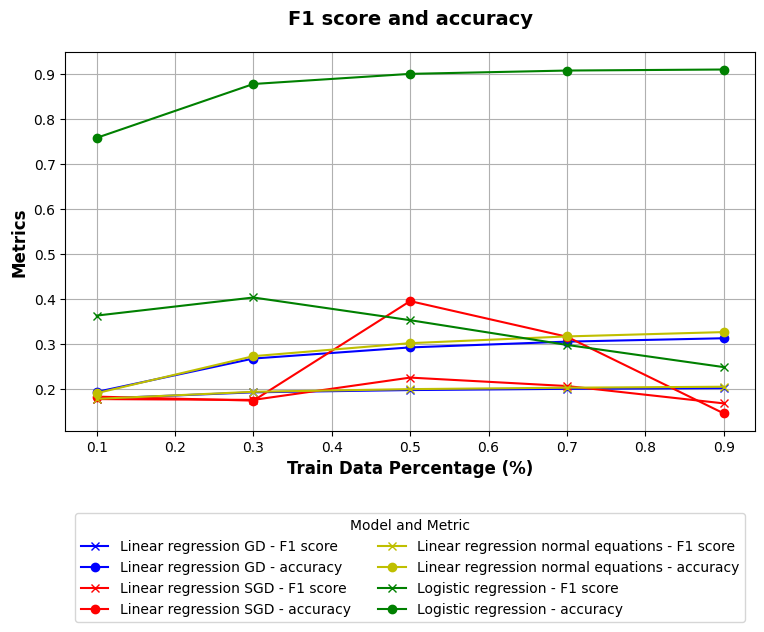

In [33]:
import matplotlib.lines as mlines

plt.figure(figsize=(8,6.7))

plt.plot(PERCENTAGES, lin_gd_f1s, 'bx-', label='Linear regression GD - F1 score')
plt.plot(PERCENTAGES, lin_gd_accuracies, 'bo-', label='Linear regression GD - accuracy')

plt.plot(PERCENTAGES, lin_sgd_f1s, 'rx-', label='Linear regression SGD - F1 score')
plt.plot(PERCENTAGES, lin_sgd_accuracies, 'ro-', label='Linear regression SGD - accuracy')

plt.plot(PERCENTAGES, lin_ne_f1s, 'yx-', label='Linear regression normal equations - F1 score')
plt.plot(PERCENTAGES, lin_ne_accuracies, 'yo-', label='Linear regression normal equations - accuracy')

plt.plot(PERCENTAGES, log_f1s, 'gx-', label='Logistic regression - F1 score')
plt.plot(PERCENTAGES, log_accuracies, 'go-', label='Logistic regression - accuracy')

plt.xlabel('Train Data Percentage (%)', fontsize=12, weight='bold')
plt.ylabel('Metrics', fontsize=12, weight='bold')
plt.title(f'F1 score and accuracy', fontsize=14, weight='bold', pad=20)

# Adjust the legend to be outside the plot for better readability
plt.legend(title="Model and Metric", loc='upper center', bbox_to_anchor=(0.5, -0.2), frameon=True, prop={'size': 10}, ncol=2)

plt.grid(True)

plt.tight_layout()

plt.savefig('img/metrics_unp.pdf', bbox_inches='tight')

plt.show()

#### Tuning the hyperparameter lambda for penalized methods

In [15]:
N_FOLDS = 4
LEARNING_RATE = 0.05
THRESHOLD = 0.5
MAX_ITERS = 1000
INITIAL_W = np.ones(D)
LAMBDAS = np.logspace(-3, 0, 4)

Regularized logistic regression

In [16]:
PERCENTAGE = 0.3

folds = balanced_k_folds(y_train_final, N_FOLDS)

reg_f1s = np.zeros(len(LAMBDAS))
reg_accuracies = np.zeros(len(LAMBDAS))


for j, lambda_ in enumerate(LAMBDAS):
    la_f1s = np.zeros(N_FOLDS)
    la_accuracies = np.zeros(N_FOLDS)
    
    for i in range(N_FOLDS):
        fold = folds[i]
        rest = np.setdiff1d(np.arange(N), fold)
            
        loc_y_val = y_train_final[fold]
        loc_x_val = x_train_final[fold, :]
        loc_y_train = y_train_final[rest]
        loc_x_train = x_train_final[rest, :]
        loc_x_train, loc_y_train = remove_percentage(loc_x_train, loc_y_train, PERCENTAGE)

        w, _ =  reg_logistic_regression(loc_y_train, loc_x_train, lambda_, INITIAL_W, MAX_ITERS, LEARNING_RATE)
        
        la_accuracies[i], la_f1s[i] = accuracy_f1(loc_y_val, loc_x_val, w, THRESHOLD)
        
    
    reg_f1s[j] = np.mean(la_f1s)
    reg_accuracies[j] = np.mean(la_accuracies)

Ridge regression

In [17]:
PERCENTAGE = 0.9

# folds = balanced_k_folds(y_train, N_FOLDS)

rid_f1s = np.zeros(len(LAMBDAS))
rid_accuracies = np.zeros(len(LAMBDAS))

for j, lambda_ in enumerate(LAMBDAS):
    la_f1s = np.zeros(N_FOLDS)
    la_accuracies = np.zeros(N_FOLDS)
    
    for i in range(N_FOLDS):
        fold = folds[i]
        rest = np.setdiff1d(np.arange(N), fold)
            
        loc_y_val = y_train_final[fold]
        loc_x_val = x_train_final[fold, :]
        loc_y_train = y_train_final[rest]
        loc_x_train = x_train_final[rest, :]
        loc_x_train, loc_y_train = remove_percentage(loc_x_train, loc_y_train, PERCENTAGE)

        w, _ =  ridge_regression(loc_y_train, loc_x_train, lambda_)
        la_accuracies[i], la_f1s[i] = accuracy_f1(loc_y_val, loc_x_val, w, THRESHOLD)
        

    rid_f1s[j] = np.mean(la_f1s)
    rid_accuracies[j] = np.mean(la_accuracies)

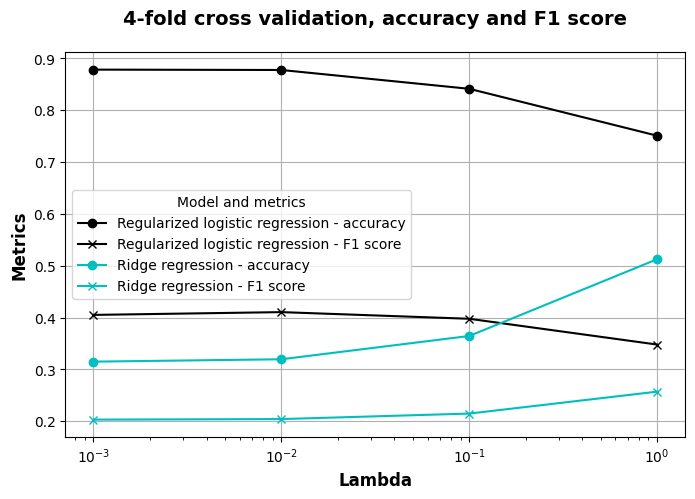

In [18]:
plt.figure(figsize=(8,5))
plt.plot(LAMBDAS, reg_accuracies, 'ko-', label=f'Regularized logistic regression - accuracy')
plt.plot(LAMBDAS, reg_f1s, 'kx-', label=f'Regularized logistic regression - F1 score')

plt.plot(LAMBDAS, rid_accuracies, 'co-', label=f'Ridge regression - accuracy')
plt.plot(LAMBDAS, rid_f1s, 'cx-', label=f'Ridge regression - F1 score')

plt.xlabel('Lambda', fontsize=12, weight='bold')
plt.ylabel('Metrics',  fontsize=12, weight='bold')
plt.title(f'{N_FOLDS}-fold cross validation, accuracy and F1 score', fontsize=14, weight='bold', pad=20)
plt.legend(title="Model and metrics")
plt.xscale('log')
plt.grid(True)

plt.savefig('img/metrics_pen.pdf')

plt.show()

## Comparison sul final validation set

In [19]:
MAX_ITERS = 1000
LEARNING_RATE = 0.05
INITIAL_W = np.ones(D)
PERCENTAGE = 0.3
LAMBDA_ = 0.01
THRESHOLD = 0.5

In [20]:
# logistic regression with optimal parameter p = 0.3

x_train_small, y_train_small = remove_percentage(loc_x_train, loc_y_train, PERCENTAGE)

w_unp, _ = logistic_regression(y_train_small, x_train_small, INITIAL_W, MAX_ITERS, LEARNING_RATE)
w_pen, _ = reg_logistic_regression(y_train_small, x_train_small, LAMBDA_, INITIAL_W, MAX_ITERS, LEARNING_RATE)

accuracy_unp, f1_unp = accuracy_f1(y_val_final, x_val_final, w_unp, THRESHOLD)
accuracy_pen, f1_pen = accuracy_f1(y_val_final, x_val_final, w_pen, THRESHOLD)


In [21]:
print("accuracy for penalized model: ", accuracy_pen)
print("f1 score for penalized model: ", f1_pen)

print("accuracy for unpenalized model: ", accuracy_unp)
print("f1 score for unpenalized model: ", f1_unp)

accuracy for penalized model:  0.8656670933138295
f1 score for penalized model:  0.4068891280947255
accuracy for unpenalized model:  0.8677393795331261
f1 score for unpenalized model:  0.4018743109151047


In [22]:
# best model is penalized logistic regression
# we save its weights

np.save('weights.npy', w_pen)